In [1]:
import sys 
sys.path.append("..")
import numpy as np
import numpy.linalg as LA
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
import seaborn as sns
from utils.my_plotting_lib import plotBarcodes, plotConfidenceEllipse, labelAxes
from textwrap import fill
rc('text', usetex=True)
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

__Table of contents__
1. [Distortion models based on basic statistical distributions](#statdist)
2. [Distortion due to cell image segmentation noise](#segmentation)
3. [Distortion due to inefficient probe binding in smFISH](#probe_binding)

# Distortion models based on basic statistical distributions <a class="anchor" id="statdist"></a>

In [2]:
labels = {
        'exact': f'smFISH exact',
        'binomial': f'smFISH missing spots (uniform rate)',
        'binomial_state_dep': f'smFISH missing spots (varying rate)',
        'flowcyt': f'Integrated fluorescence intensity',
        'poisson_noise': f'Additive Poisson noise',
        'poisson_observation': 'Poisson observation'
}

colors = {
        'exact': f'red',
        'binomial': f'blue',
        'poisson_observation': 'k',
        'binomial_state_dep': f'brown',
        'poisson_noise': 'orange',
        'flowcyt': f'darkgreen'
}

with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/bursting_parameters.npz') as par:
    kon = par['kon']
    koff = par['koff']
    alpha = par['alpha']
    gamma = par['gamma']

theta = np.array([kon, koff, alpha, gamma])

measurement_methods = ['exact', 'binomial', 'binomial_state_dep', 'flowcyt', 'poisson_noise', 'poisson_observation']

## D-optimal sampling periods for different types of measurements

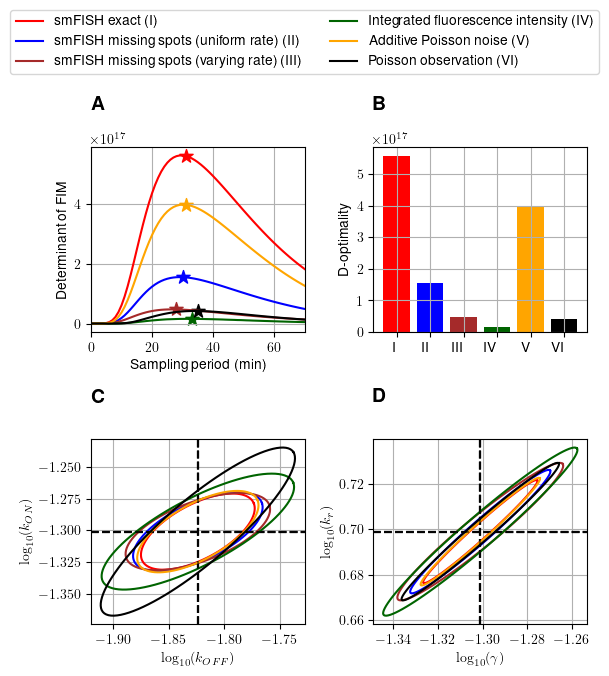

In [3]:
with np.load("results/opt_sampling_periods.npz", allow_pickle=True) as _:
    opt_rates = _["opt_rates"][()]
    fim_multi_cells_times = _["fim_multi_cells_times"][()]
    det_fim_multi_cells_times = _["det_fim_multi_cells_times"][()]

roman_numerics = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']

DT_MAX = 70
fig, axs = plt.subplots(2,2)
fig.set_size_inches(6, 6)
fig.set_tight_layout(True)
for im, meas in enumerate(measurement_methods):
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    dt_array = np.linspace(0, len(dets)-1, len(dets))
    
    axs[0,0].plot(dt_array, dets, label=f"{labels[meas]} ({roman_numerics[im]})", color=colors[meas])
    axs[0,0].scatter(dt_array[idx_opt],
                   dets[idx_opt],
               100,
               color=colors[meas],
                   marker='*')

    axs[0,1].bar(im, dets[idx_opt], color=colors[meas])

    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[1,0],
                      [1,0],
                      np.log10(theta),
                      colors[meas], '')
    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[1,1],
                      [3,2],
                      np.log10(theta), colors[meas], '')

h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower center', ncol=2)
axs[0, 0].set_xlim([0, DT_MAX])
axs[0, 0].set_xlabel('Sampling period (min)')
axs[0, 0].set_ylabel('Determinant of FIM')

axs[0, 1].set_ylabel('D-optimality')
axs[0, 1].set_xticks(range(len(measurement_methods)))
axs[0, 1].set_xticklabels(roman_numerics[:len(measurement_methods)], ha='right')

axs[1,0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1,0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1,1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1,1].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs.flatten()):
    ax.grid(True)
labelAxes(axs)
fig.savefig('figs/bursting_fim_dopt.png', bbox_inches='tight', dpi=400)

## Precise numerical comparison of D-optimal designs

In [4]:
import pandas as pd

lst = []
for design in measurement_methods:
    dt_opt = opt_rates[design]
    d_opt = det_fim_multi_cells_times[design][dt_opt]
    lst.append(
        [labels[design],
        dt_opt,
        d_opt]
    )
df = pd.DataFrame(lst, columns=['Design', 'Optimal sampling period (minute)', 'D-optimal information'])
df.to_csv("tables/bursting_designs.csv", index=False, float_format="%.2e")

## Heatmaps for the probability kernels

/Users/huyvo/miniforge3/envs/cme/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/Users/huyvo/miniforge3/envs/cme/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


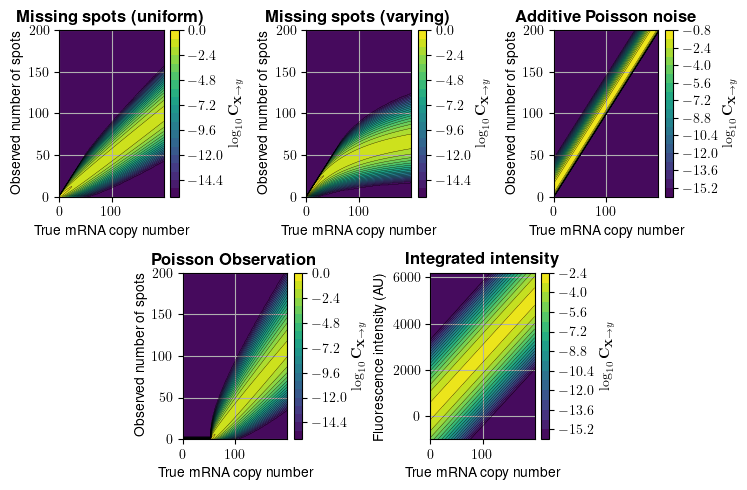

In [41]:
import matplotlib.colors as Colors
pdos = {}
yranges = {}
for s in ["binomial", "binomial_state_dep", "poisson_noise", "poisson_observation", "flowcyt"]:
    with np.load(f'results/distortion_matrix_{s}.npz') as data:
        pdos[s] = data['C']
        yranges[s] = data['yrange']
pdo_colors = ["Blues",  "Purples", "YlOrBr", "Greys", "Greens"]

fig = plt.figure(figsize=(7.5, 5), tight_layout=True)
axs = list(fig.subplot_mosaic("""
                        AABBCC
                        .DDEE.
                        """).values())

for i,s in enumerate(pdos.keys()):
    C = pdos[s][:, :200]
    p = axs[i].contourf(range(0, 200), yranges[s], np.log10(np.maximum(C, 1e-16)), levels=20)
    axs[i].contour(range(0, 200), yranges[s], np.log10(np.maximum(C, 1e-16)), colors="k", levels=20, linestyles="solid", linewidths=0.25)
    # p = axs[i].pcolorfast(range(0,200), yranges[s], C, norm=Colors.LogNorm(vmin=1.0E-6),
    #                      cmap=plt.cm.get_cmap(pdo_colors[i]))
    fig.colorbar(p, ax=axs[i], orientation='vertical', extend='min', label=r"$\log_{10}\mathbf{C}_{\mathbf{X}\rightarrow y}$")

for j in range(0,4):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Observed number of spots')
    axs[j].set_ylim([0, 200])
axs[4].set_xlabel('True mRNA copy number')
axs[4].set_ylabel('Fluorescence intensity (AU)')

models = ['Missing spots (uniform)',
          'Missing spots (varying)',
          "Additive Poisson noise",
          'Poisson Observation',
          'Integrated intensity']
for j in range(len(models)):
    axs[j].set_title(rf'\textbf{{{models[j]}}}', ha='center')
    axs[j].grid()
fig.savefig('figs/bursting_kernel_maps.jpg', bbox_inches='tight', dpi=200)

## MLE validation for binomial noise model with varying rate


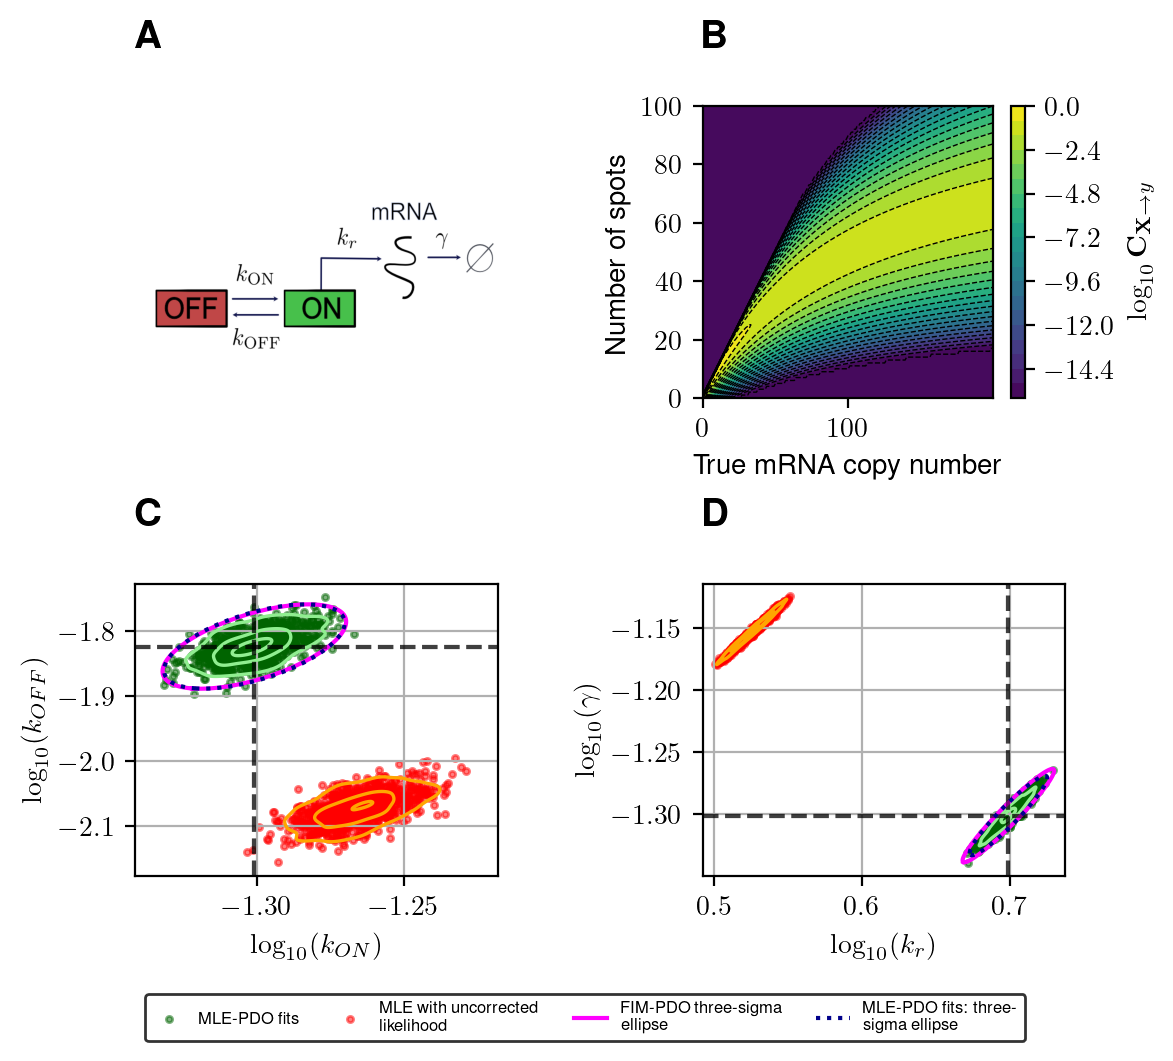

In [40]:
with np.load("results/ge_mle_fits.npz") as _:
    corrected_data_fits = _["fits_correct"]
    uncorrected_data_fits = _["fits_incorrect"]

fig = plt.figure(figsize=(6, 5), dpi=200)
axs = list(fig.subplot_mosaic(
"""
AAAA..BBBB
AAAA..BBBB
..........
CCCC..DDDD
CCCC..DDDD
"""
).values())

axs[0].axis("off")
bursting_schematic = plt.imread("figs/bursting_schematic.png")
axs[0].imshow(bursting_schematic, aspect='auto')
axs[0].set_xticks([])
axs[0].set_yticks([])

C = pdos["binomial_state_dep"][:, :200]
p = axs[1].contourf(np.log10(np.maximum(C, 1e-16)), levels=20)
axs[1].contour(np.log10(np.maximum(C, 1e-16)), colors="k", levels=20, linewidths=0.5)
# p = axs[1].pcolorfast(C, norm=Colors.LogNorm(vmin=1.0E-6),
#                          cmap=matplotlib.colormaps.get_cmap(pdo_colors[1]))
fig.colorbar(p, ax=axs[1], orientation='vertical', extend='min', label=r"$\log_{10}\mathbf{C}_{\mathbf{X}\rightarrow y}$")
axs[1].set_xlabel('True mRNA copy number')
axs[1].set_ylabel('Number of spots')
axs[1].set_ylim([0, 100])

sample_cov_correct = np.cov(corrected_data_fits, rowvar=False)

for i, pair in enumerate([[0, 1], [2, 3]]):
    axs[2+i].grid(True)

    axs[2+i].scatter(corrected_data_fits[:, pair[0]], corrected_data_fits[:, pair[1]], 5, color="darkgreen", label="MLE-PDO fits", alpha=0.5)
    axs[2+i].scatter(uncorrected_data_fits[:, pair[0]], uncorrected_data_fits[:, pair[1]], 5, color="red", label="MLE with uncorrected likelihood", alpha=0.5)

    # Prepare dataframe for seaborn kde plot
    df_for_plot = pd.DataFrame(
        {
            "p0": np.concatenate((corrected_data_fits[:, pair[0]], uncorrected_data_fits[:, pair[0]])),
            "p1": np.concatenate((corrected_data_fits[:, pair[1]], uncorrected_data_fits[:, pair[1]])),
            "method": 1000*["MLE-PDO fits"] + 1000*["MLE with uncorrected likelihood"]
        }
    )

    sns.kdeplot(data=df_for_plot,
                x="p0",
                y="p1",
                hue=df_for_plot["method"],
                common_norm=True, ax=axs[2+i], legend=False, levels=[0.1, 0.5, 0.9], linewidths=1.2,
                palette={"MLE-PDO fits": "lightgreen", "MLE with uncorrected likelihood": "orange"})

    plotConfidenceEllipse(fim_multi_cells_times["binomial_state_dep"][30],
                  3,
                  axs[2+i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "magenta", 'FIM-PDO three-sigma ellipse')


    plotConfidenceEllipse(np.linalg.inv(sample_cov_correct),
                  3,
                  axs[2+i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkblue", 'MLE-PDO fits: three-sigma ellipse', ':')

axs[2].set_xlabel('$\log_{10}({k_{ON}})$')
axs[2].set_ylabel('$\log_{10}({k_{OFF}})$')
axs[3].set_xlabel('$\log_{10}({k_{r}})$')
axs[3].set_ylabel('$\log_{10}({\gamma})$')

labelAxes(axs)

h, l = axs[3].get_legend_handles_labels()
l = [fill(label, 20) for label in l]
fig.legend(h, l, bbox_to_anchor=(0, -1, 1, 1), loc="upper center", ncol=4, fontsize=6, edgecolor="black")
fig.savefig("figs/bursting_mle.jpg", dpi=300, bbox_inches="tight")

In [7]:
geyser = sns.load_dataset("geyser")

In [8]:
geyser

,duration,waiting,kind
0,3.600,79,long
1,1.800,54,short
2,3.333,74,long
3,2.283,62,short
4,4.533,85,long
...,...,...,...
267,4.117,81,long
268,2.150,46,short
269,4.417,90,long
270,1.817,46,short


In [9]:
theta.reshape((1,4))

array([[0.05 , 0.015, 5.   , 0.05 ]])

In [10]:
def compute_fit_performance_stats(fits: np.ndarray, true_parameters: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    true_parameters = np.reshape(true_parameters, (1, -1))
    means = np.mean(fits, axis=0)
    stds = np.std(fits, axis=0)
    relative_rmse = np.sqrt(
            np.mean(
                (fits - true_parameters)**2.0,
                axis=0
            )
    )/np.abs(true_parameters)
    relative_rmse = relative_rmse.flatten()
    return means, stds, relative_rmse

corrected_means, corrected_stds, corrected_rmse = compute_fit_performance_stats(corrected_data_fits, np.log10(theta))
uncorrected_means, uncorrected_stds, uncorrected_rmse = compute_fit_performance_stats(uncorrected_data_fits, np.log10(theta))
corrected_col = [f"{x: .2e} ({y: .2e})" for (x,y) in zip(corrected_means, corrected_stds)]
uncorrected_col = [f"{x: .2e} ({y: .2e})" for (x,y) in zip(uncorrected_means, uncorrected_stds)]
df = pd.DataFrame({
              "Parameter": ["$\log_{10}(k_{OFF})$", "$\log_{10}(k_{ON})$", "$\log_{10}(k_r)$", "$\log_{10}(\gamma)$"],
              "True Value": [f"{x: .2e}" for x in np.log10(theta)],
              "Corrected Fits":  corrected_col,
              "Uncorrected Fits": uncorrected_col,
              "Corrected relRMSE": [f"{x: .2e}" for x in corrected_rmse],
              "Uncorrected relRMSE": [f"{x: .2e}" for x in uncorrected_rmse]
              },
             )
df.to_csv(path_or_buf="tables/bursting_mle.csv", index=False)


## Effect of binning

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_10979/1336674565.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("winter")


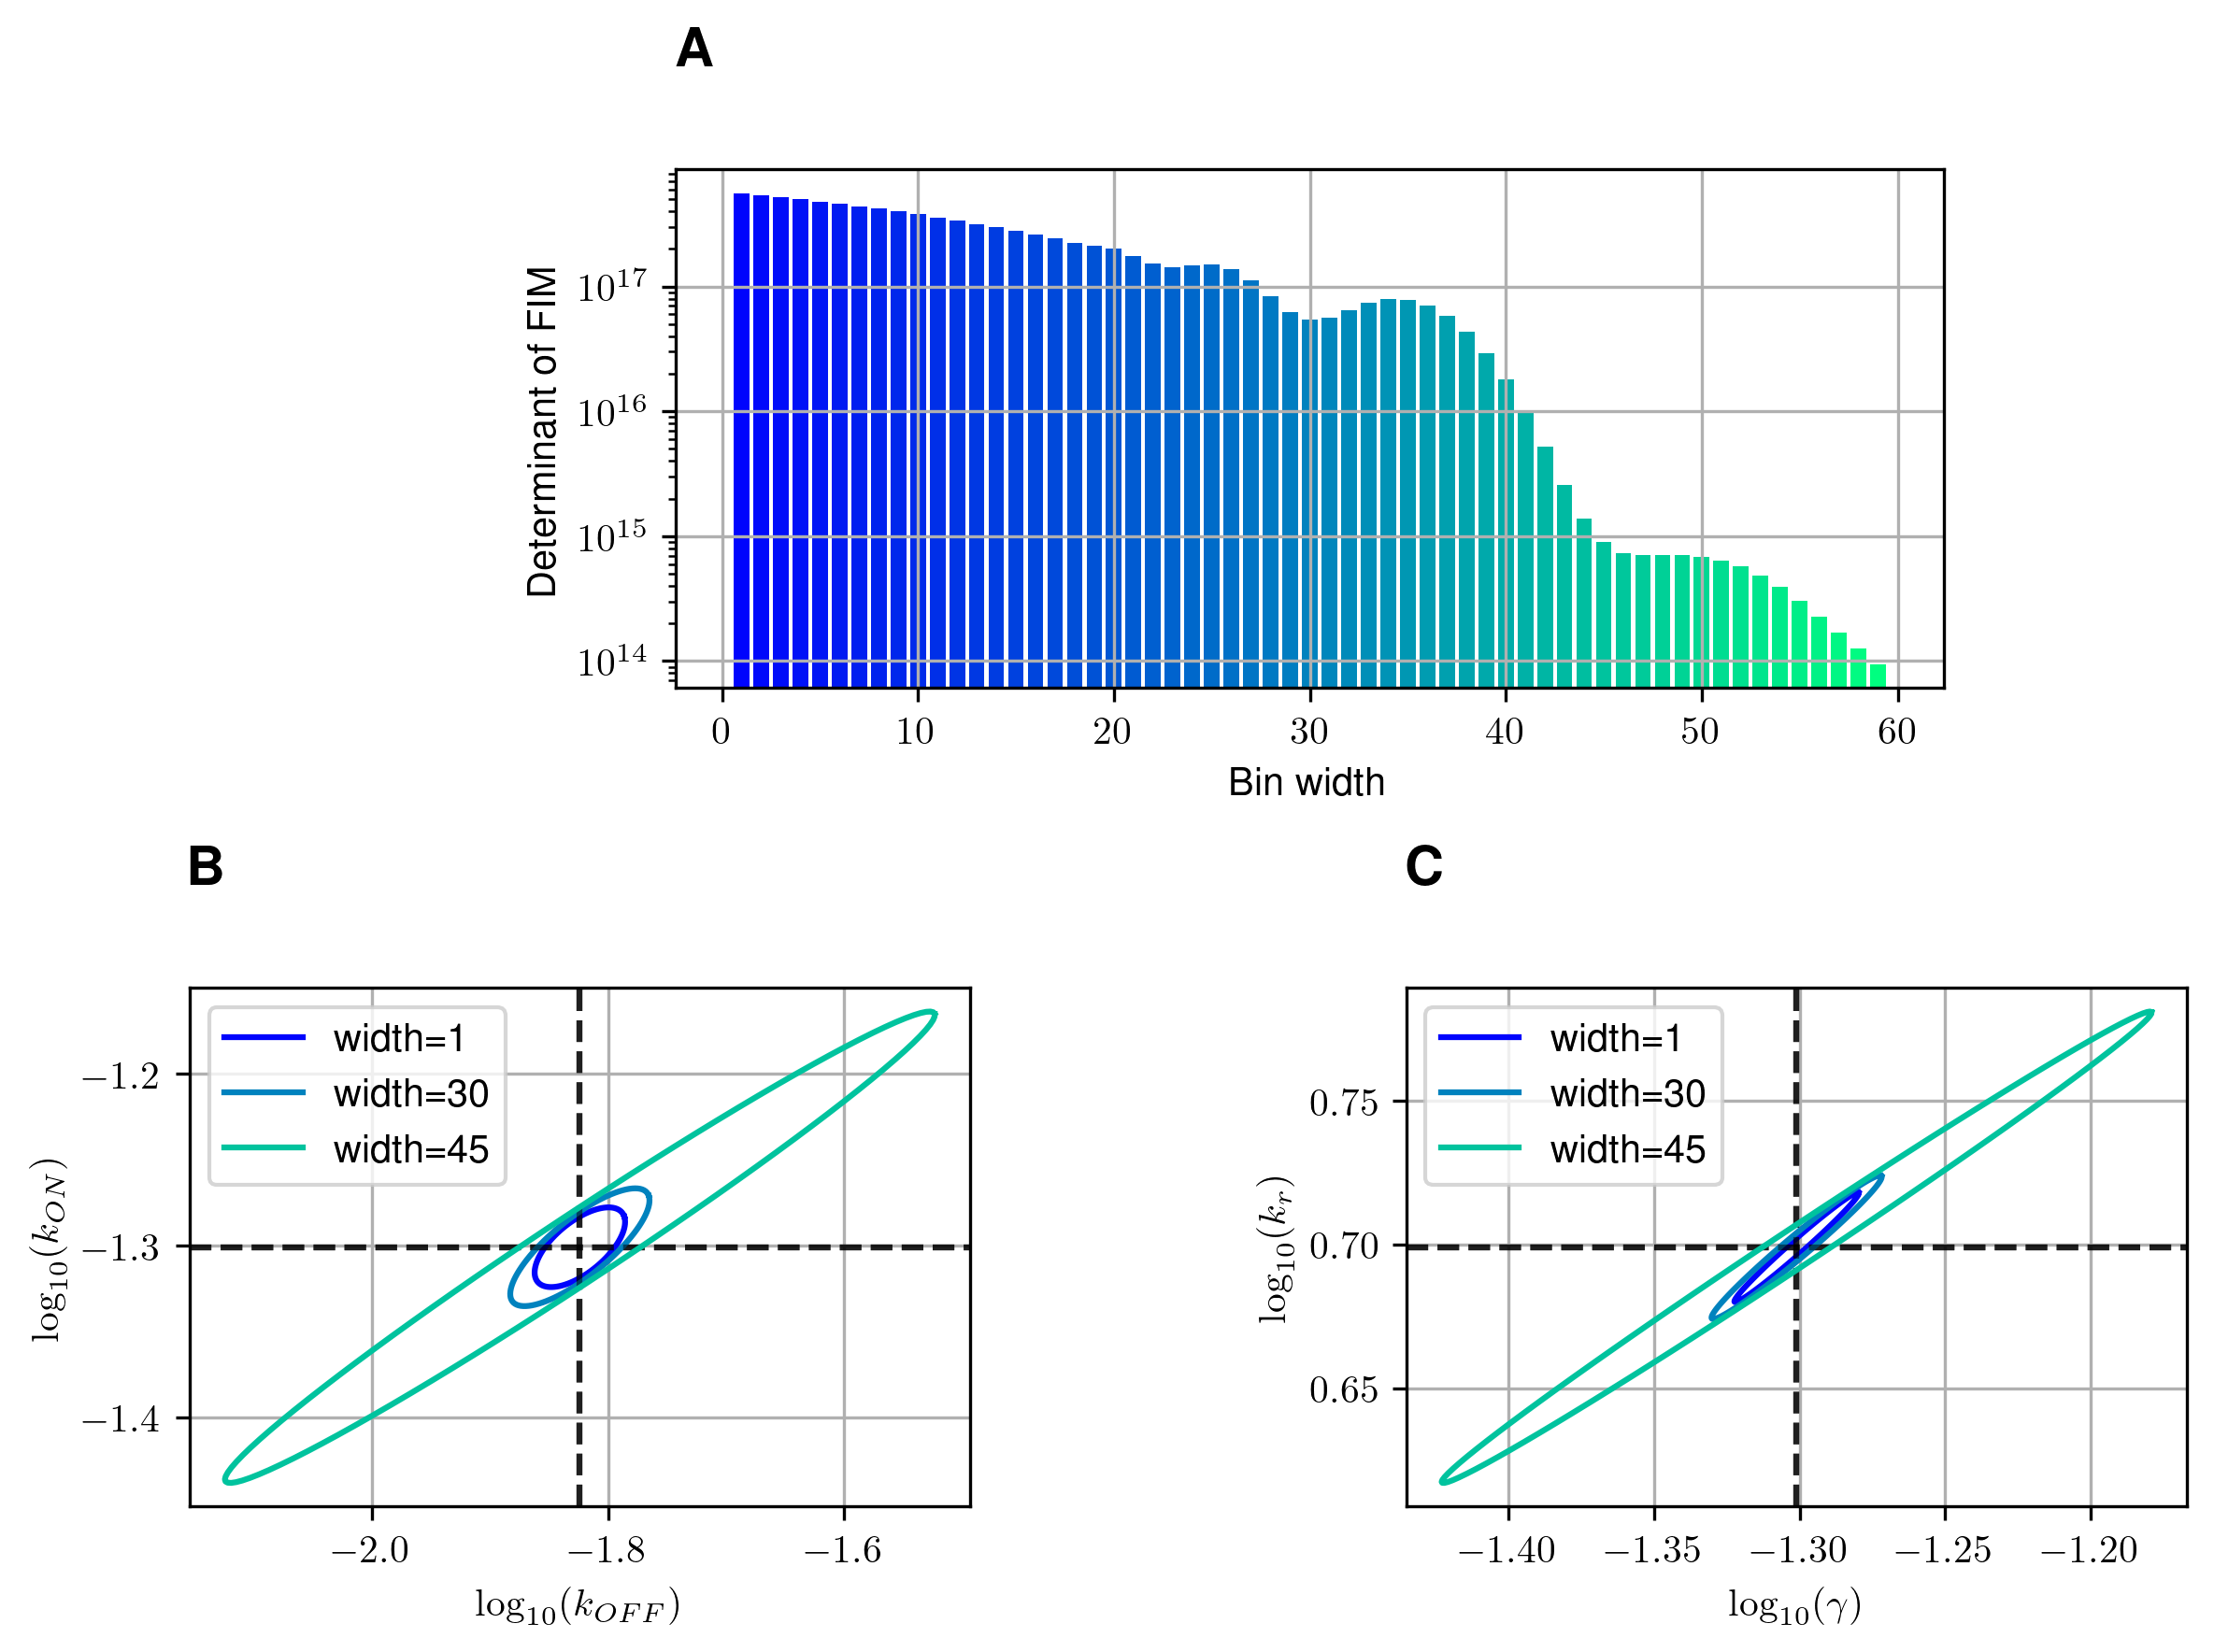

In [11]:
with np.load("results/binning_sweep.npz", allow_pickle=True) as _:
    binWidths = _["binWidths"]
    fimDets = _["fimDets"]
    fims = _["fims"][()]


fig = plt.figure(figsize=(8, 6), dpi=300, tight_layout=True)
axs = list(fig.subplot_mosaic(
"""
..AAAAAA.
..AAAAAA.
BBBB.CCCC
BBBB.CCCC
"""
).values())

cm = plt.cm.get_cmap("winter")
for i in [0, 30, 45]:
    color = cm(binWidths[i]/np.max(binWidths))

    plotConfidenceEllipse(fims[binWidths[i]],
                      3,
                      axs[1],
                      [1,0],
                      np.log10(theta),
                      color, f'width={binWidths[i]}')
    plotConfidenceEllipse(fims[binWidths[i]],
                      3,
                      axs[2],
                      [3,2],
                      np.log10(theta), color, f'width={binWidths[i]}')

for i in range(fimDets.shape[0]):
    color = cm(binWidths[i]/np.max(binWidths))
    axs[0].bar(binWidths[i], fimDets[i], color=color)

axs[0].set_xlabel("Bin width")
axs[0].set_ylabel("Determinant of FIM")
axs[0].set_yscale("log")
axs[0].grid(True)

for ax in [axs[1], axs[2]]:
    ax.grid()
    ax.legend()
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')
axs[2].set_xlabel('$\log_{10}({\gamma})$')


labelAxes(axs)

fig.savefig("figs/bursting_binning.png", dpi=300)

# Distortion due to cell image segmentation noise <a class="anchor" id="segmentation"></a>

## MLE validations for the cell image mis-segmentation noise in SI

In [12]:
fim = fim_multi_cells_times["binomial_state_dep"][30]
fim_cov = np.linalg.inv(fim)

In [13]:
with np.load("results/double_cell_fims.npz", allow_pickle=True) as _:
    cell_merging_rates = _["error_rates"]
    cell_merging_fims = _["fim_analyses"][()]

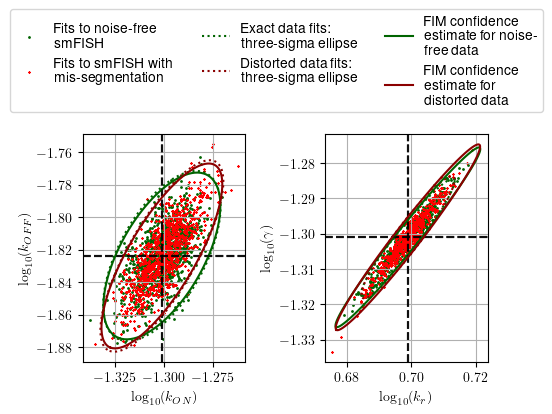

In [14]:
from textwrap import fill

with np.load("results/double_cell_mle_fits.npz") as _:
    corrected_data_fits = _["exact_data_fits"]
    uncorrected_data_fits = _["distorted_data_fits"]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(5,3)
fig.set_tight_layout(True)

exact_fits_cov = np.cov(corrected_data_fits, rowvar=False)
distorted_fits_cov = np.cov(uncorrected_data_fits, rowvar=False)
for i, pair in enumerate([[0, 1], [2, 3]]):
    axs[i].grid(True)
    #
    axs[i].scatter(corrected_data_fits[:, pair[0]], corrected_data_fits[:, pair[1]], 1, color="darkgreen", label="Fits to noise-free smFISH")
    axs[i].scatter(uncorrected_data_fits[:, pair[0]], uncorrected_data_fits[:, pair[1]], 1, color="red", label="Fits to smFISH with mis-segmentation", marker="x")

    plotConfidenceEllipse(np.linalg.inv(exact_fits_cov),
                  3,
                  axs[i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkgreen", 'Exact data fits: three-sigma ellipse', ':')

    plotConfidenceEllipse(np.linalg.inv(distorted_fits_cov),
                  3,
                  axs[i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkred", 'Distorted data fits: three-sigma ellipse', ':')

    plotConfidenceEllipse(fim_multi_cells_times["exact"][30],
                          3,
                          axs[i],
                          [pair[0],pair[1]],
                          np.log10(theta),
                          "darkgreen",
                          "FIM confidence estimate for noise-free data")

    plotConfidenceEllipse(cell_merging_fims[1.0]["fims_experiment"][30],
                          3,
                          axs[i],
                          [pair[0],pair[1]],
                          np.log10(theta),
                          "darkred",
                          "FIM confidence estimate for distorted data")



axs[0].set_xlabel('$\log_{10}({k_{ON}})$')
axs[0].set_ylabel('$\log_{10}({k_{OFF}})$')
axs[1].set_xlabel('$\log_{10}({k_{r}})$')
axs[1].set_ylabel('$\log_{10}({\gamma})$')


h, labels = axs[0].get_legend_handles_labels()
labels = [fill(label, 20) for label in labels]
fig.legend(h, labels, bbox_to_anchor=(0, 1, 0, 0), loc="lower left", ncol=3)
fig.savefig("figs/bursting_missegmentation_mle.png", dpi=300, bbox_inches="tight")

## Compare D-optimal designs across different levels of segmentation noise

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_10979/1465013656.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("tab10")


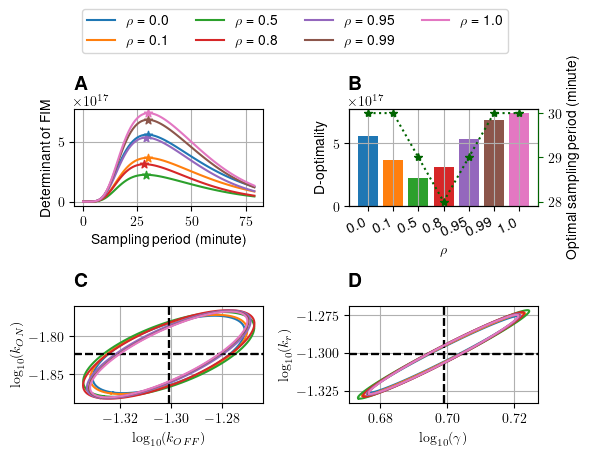

In [15]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(6, 4)
fig.set_tight_layout(True)
cm = plt.cm.get_cmap("tab10")

for i, rate in enumerate(cell_merging_rates):
    color = cm(i)#cm(level/max(probeLevels))

    dets = cell_merging_fims[rate]["fims_dets_experiment"]
    dt_opt = cell_merging_fims[rate]["dt_opt"]
    fims = cell_merging_fims[rate]["fims_experiment"]


    axs[0, 0].plot(dets, color=color, label=rf"$\rho$ = {rate}")
    axs[0, 0].scatter(dt_opt, dets[dt_opt], color=color, marker="*")

    axs[0, 1].bar(i, dets[dt_opt], color=color)

    plotConfidenceEllipse(fim=fims[dt_opt], num_sigma=3, color=color, ax=axs[1, 0], theta=np.log10(theta), par_idx=[0, 1])
    plotConfidenceEllipse(fim=fims[dt_opt], num_sigma=3, color=color, ax=axs[1, 1], theta=np.log10(theta), par_idx=[2, 3])

axs01twin = axs[0, 1].twinx()
axs01twin.plot(range(0,len(cell_merging_rates)), [cell_merging_fims[rate]["dt_opt"] for rate in cell_merging_rates], marker="*", ls=":", color="darkgreen")
axs01twin.set_ylabel("Optimal sampling period (minute)")
axs01twin.spines["right"].set_color("darkgreen")
axs01twin.tick_params(axis="y", color="darkgreen")

axs[0, 0].set_xlabel("Sampling period (minute)")
axs[0, 0].set_ylabel("Determinant of FIM")
axs[0, 1].set_ylabel("D-optimality")
axs[0, 1].set_xticks(range(len(cell_merging_rates)))
axs[0, 1].set_xticklabels(cell_merging_rates, rotation=25, ha='right')
axs[0, 1].set_xlabel(r"$\rho$")

axs[1, 0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1, 0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1, 1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1, 1].set_xlabel('$\log_{10}({\gamma})$')

for ax in axs.flatten():
    ax.grid(True)

h, l = axs[0, 0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0, 1, 1, 1), ncol=4)
labelAxes(axs)

fig.savefig("figs/bursting_missegmentation_fims.png", dpi=300, bbox_inches="tight")

# Distortion due to inefficient probe binding in smFISH <a class="anchor" id="probe_binding"></a>

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_10979/489219680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("spring"),


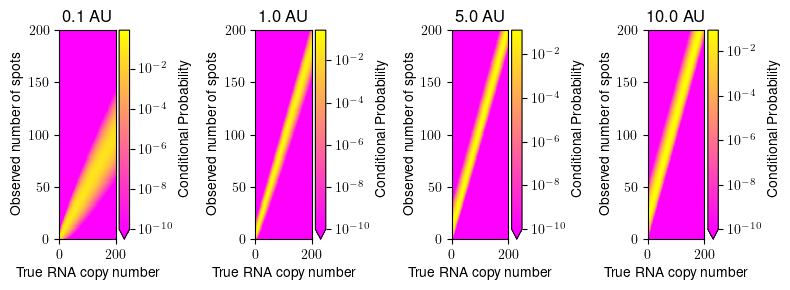

In [16]:
with np.load("results/smfish_probe_distortions.npz", allow_pickle=True) as _:
    probeLevels = _["levels"]
    probe_pdos = _["pdos"][()]

numPdos = len(probe_pdos)
fig, axs = plt.subplots(1, numPdos)
fig.set_size_inches(2*numPdos, 3)
fig.set_tight_layout(True)
for i in range(numPdos):
    heatmap = axs[i].pcolorfast(np.maximum(probe_pdos[probeLevels[i]], 1.0e-16),
                                cmap=plt.cm.get_cmap("spring"),
                                norm=Colors.LogNorm(vmin=1.0E-10))
    axs[i].set_ylim([0, 200])
    axs[i].set_xlim([0, 200])
    fig.colorbar(heatmap,  ax=axs[i], orientation='vertical', extend='min', label=r"Conditional Probability")
    axs[i].set_title(f"{probeLevels[i]} AU")
    axs[i].set_xlabel("True RNA copy number")
    axs[i].set_ylabel("Observed number of spots")
fig.savefig("figs/probe_binding_pdos.png", dpi=300, bbox_inches="tight")

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_10979/1865896523.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("tab10")


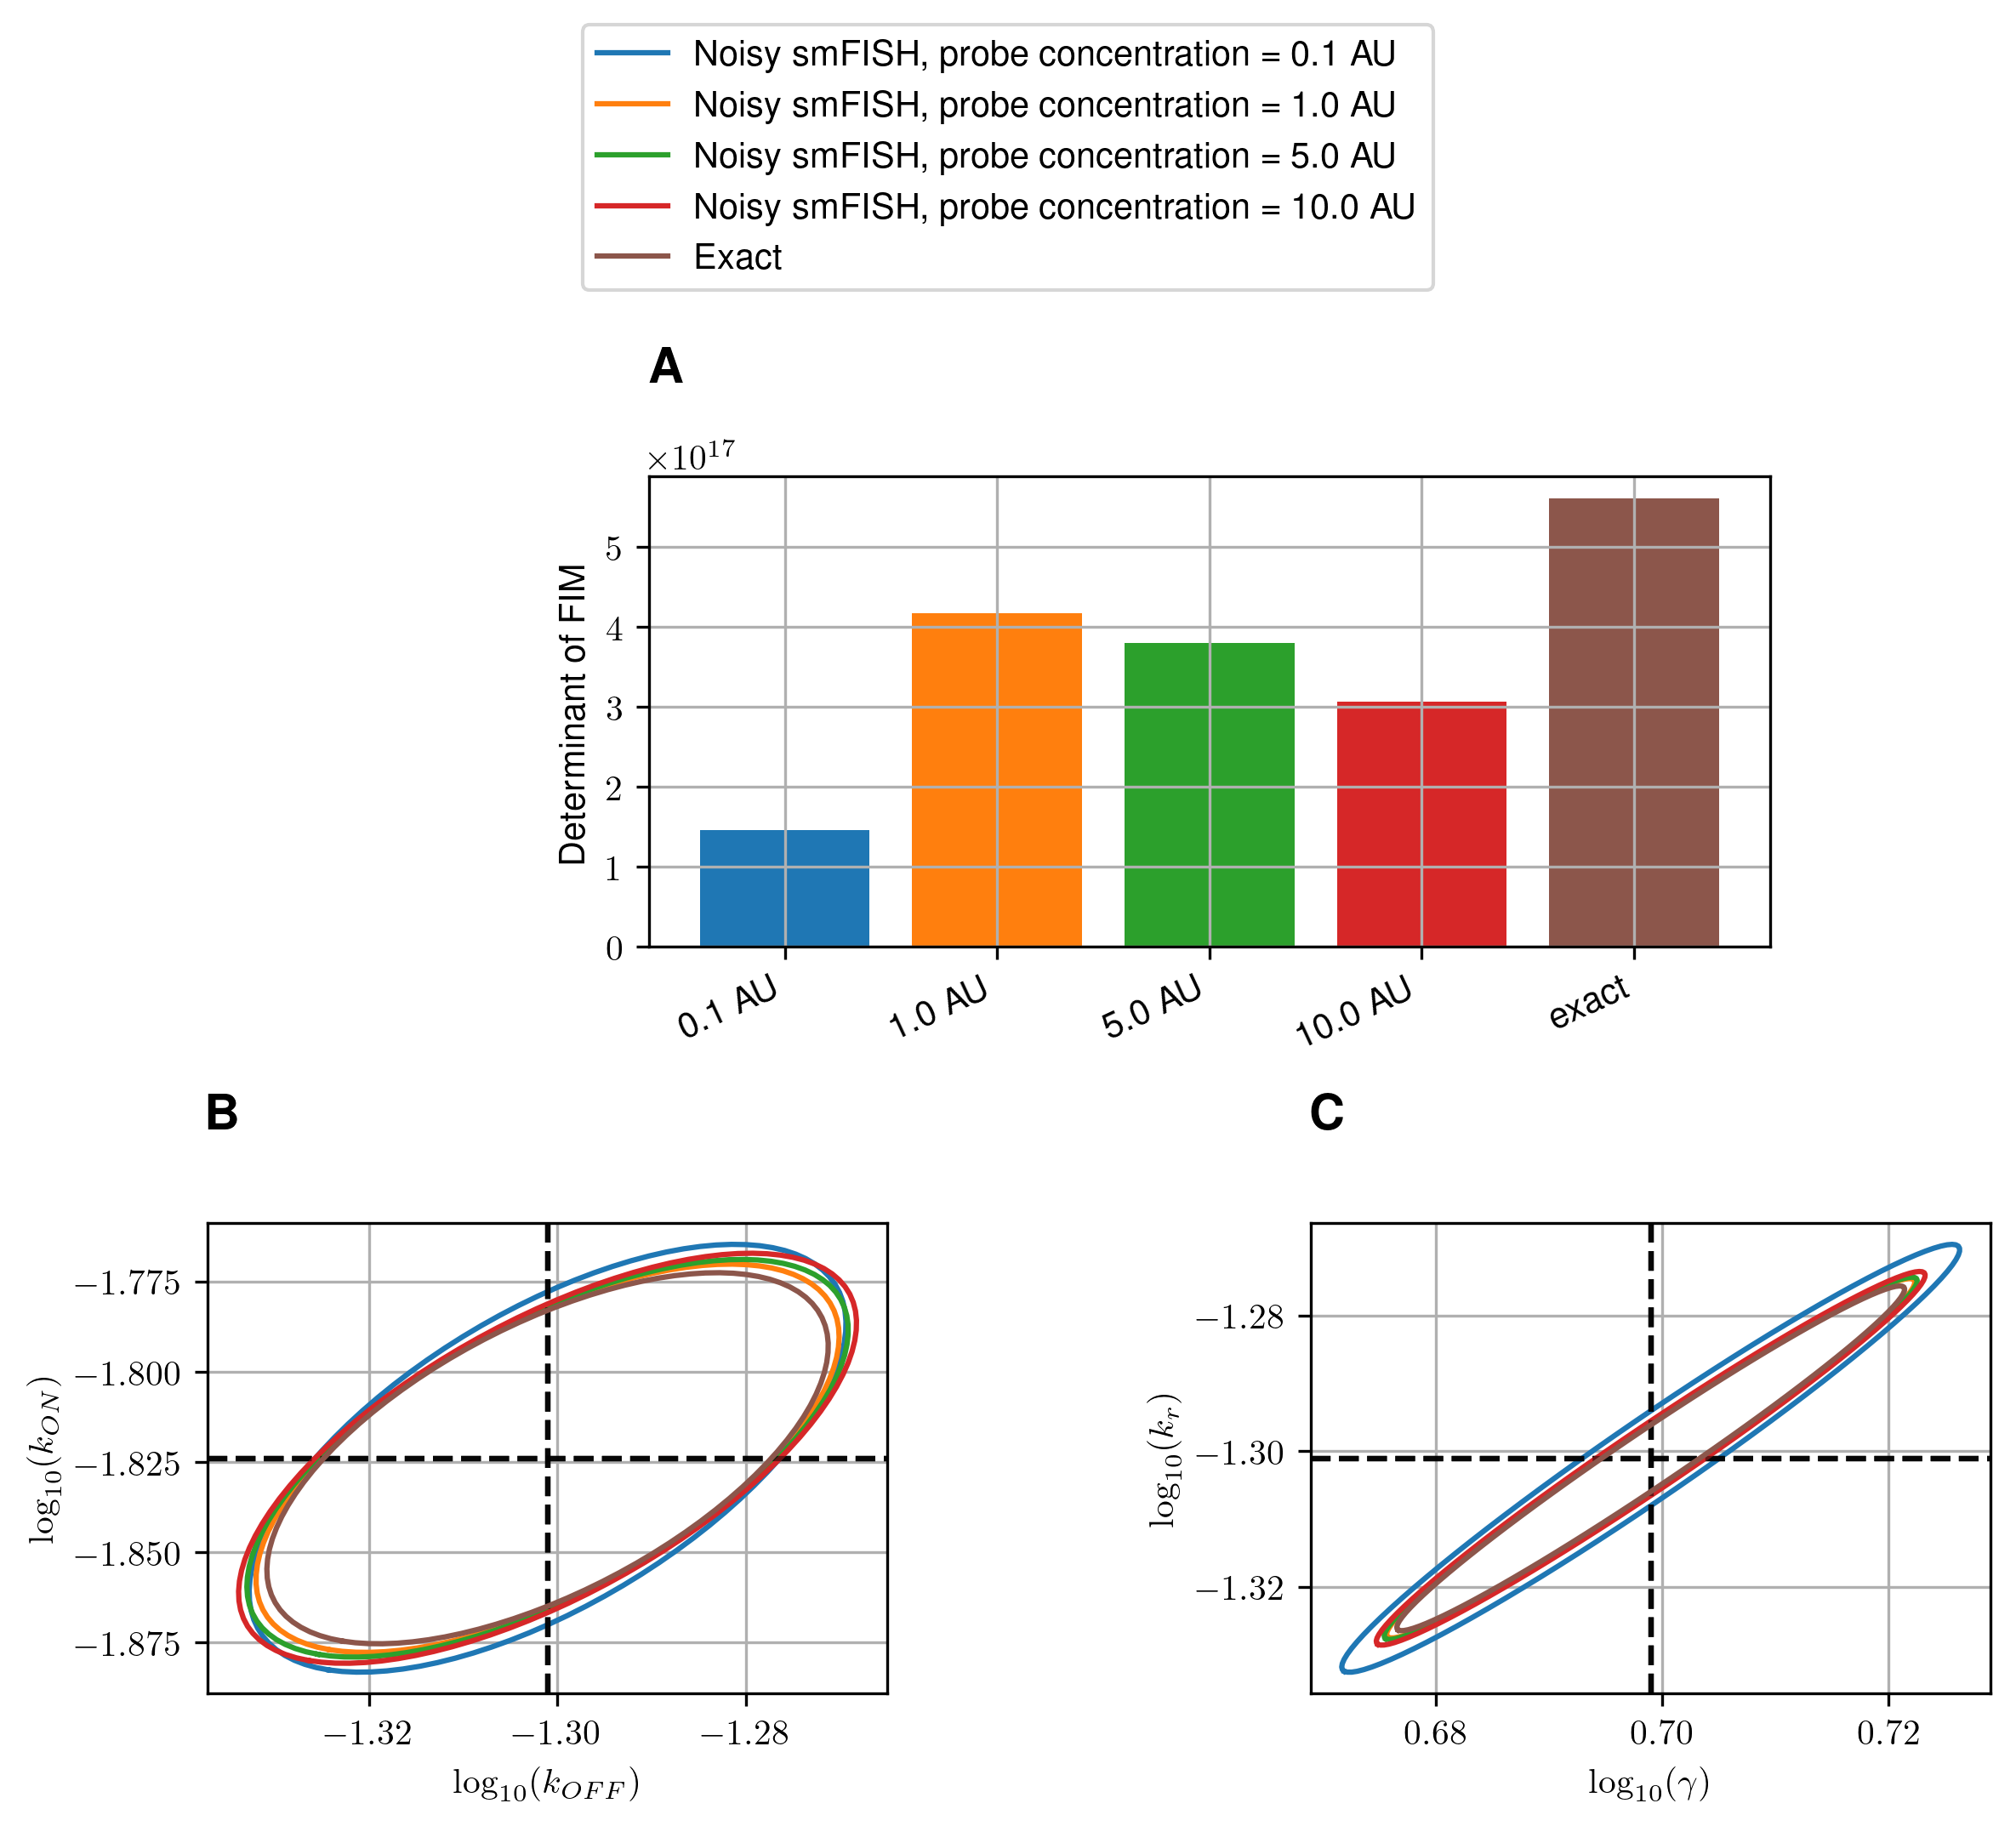

In [17]:
with np.load("results/fim_probe_binding.npz", allow_pickle=True) as _:
    fims_probe = _["fim_multi_cells_times"][()]
    dets_probe = _["det_fim_multi_cells_times"][()]
    optdt_probe = _["opt_dts"][()]

dtToPlot = 30


fig = plt.figure(figsize=(8, 6), dpi=300, tight_layout=True)
axs = list(fig.subplot_mosaic(
"""
..AAAAAA.
..AAAAAA.
BBBB.CCCC
BBBB.CCCC
"""
).values())

cm = plt.cm.get_cmap("tab10")
for i, level in enumerate(probeLevels):
    color = cm(i)#cm(level/max(probeLevels))
    axs[0].bar(i, dets_probe[level][dtToPlot], color=color)
    plotConfidenceEllipse(fim=fims_probe[level][dtToPlot], num_sigma=3, color=color, ax=axs[1], theta=np.log10(theta), par_idx=[0, 1], label=f"Noisy smFISH, probe concentration = {level} AU")
    plotConfidenceEllipse(fim=fims_probe[level][dtToPlot], num_sigma=3, color=color, ax=axs[2], theta=np.log10(theta), par_idx=[2, 3])

axs[0].bar(4, det_fim_multi_cells_times['exact'][dtToPlot], color=cm(5))
plotConfidenceEllipse(fim=fim_multi_cells_times["exact"][dtToPlot], num_sigma=3, color=cm(5), ax=axs[1], theta=np.log10(theta), par_idx=[0, 1], label="Exact")
plotConfidenceEllipse(fim=fim_multi_cells_times["exact"][dtToPlot], num_sigma=3, color=cm(5), ax=axs[2], theta=np.log10(theta), par_idx=[2, 3])

axs[0].set_ylabel("Determinant of FIM")
axs[0].set_xticks(range(5))
axs[0].set_xticklabels([f"{level} AU" for level in probeLevels] + ["exact"], rotation=25, ha='right')

axs[1].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')
axs[2].set_xlabel('$\log_{10}({\gamma})$')

for ax in axs:
    ax.grid(True)

h, l = axs[1].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0, 1, 1, 1))
labelAxes(axs)

fig.savefig("figs/bursting_probe_cme.png", dpi=300, bbox_inches="tight")